# Evaluation of model performances
Léa Bouffaut, Ph.D. 
-- K. Lisa Yang Center for Conservation Bioacoustics
-- lea.bouffaut@cornell.edu

In [1]:
# Import the necessary libraries
import csv
import audioread
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import fct_scoring

## User input

In [3]:
# model info
model_info = {
    'model_name': 'blue_whale_model_V22',
    'clip_length': 10, # s
    'overlap': 0,  # s
    'score_column': 'Confidence', # (Last column for BirdNet)
    'label_col': 'Species',
}

In [4]:
# Annotation info
performance_info = {
    'groundtruth_label_col': 'Tags',#'Type',
    'mini_sig_dur_positive': 0.1, # minimum amount of labeled duration to consider clip as a true positive for the selection
}

## Set path to folders

In [5]:
# Directories with the manual labels and model detections
path_to_manual_annotations = 'groundtruth/'
path_to_model_detections = 'model_detection/'

# Directories with the associated audio files
path_to_test_audio_files = 'test_audio/'

# A csv table with the associations of file names
# Col 1: manual annotation file // Col 2: detection file // Col 3: audio file
file_correspondance_csv = 'model_perf_file_correspondance.csv'

# Read the csv file and get the groundtruth, BirdNET and audio file lists
file_list_groundtruth = []; file_list_model = []; file_list_audio = []
with open(file_correspondance_csv, newline='') as csvfile:
    ff = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in ff:
        file_list_groundtruth.append(path_to_manual_annotations + row[0])
        file_list_model.append(path_to_model_detections + row[1])
        file_list_audio.append(path_to_test_audio_files + row[2])
        
# From the duration of each audio file determine the number of model clips
clip_number = [];
for audiofile in file_list_audio:
    with audioread.audio_open(audiofile) as sf:
        clip_number.append(int(np.ceil((sf.duration - model_info['overlap'])/(model_info['clip_length'] -model_info['overlap']))))

# Save the info in model_info
model_info['clip_number'] = clip_number
                           
# clear unnecessary variables
del path_to_manual_annotations, path_to_model_detections, path_to_test_audio_files, file_correspondance_csv

## Map label correspondance

In [6]:
# Display the labels the model was trained on
unique_labels_groundtruth = fct_scoring.get_unique_labels(file_list_model, model_info['label_col'])
print('Unique labels in the ground-truth data: ', unique_labels_groundtruth)

Unique labels in the ground-truth data:  ['ABW']


In [7]:
# Display the labels of the groundtruth test data
unique_labels_groundtruth = fct_scoring.get_unique_labels(file_list_groundtruth, performance_info['groundtruth_label_col'],delim=',')
print('Unique labels in the ground-truth data: ', unique_labels_groundtruth)

Unique labels in the ground-truth data:  ['ABW']


In [8]:
# Remap the Labels of the groundtruth to match training as needed
# Labels that are not listed won't be evaluated
# Background is the rejected class // no GT for seals or humpback

label_correspondance_map = {
    # 'groundtruth label': 'model label', 
    'ABW': 'ABW',
}

## Evaluate model performances and plot
Performance: 
   * precision = tp/(tp + fp)
   * recall = tp/(tp + fn)

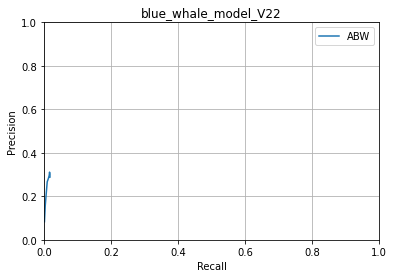

In [9]:
threshold = list(np.arange(0,1,0.1))
precision, recall, list_labels = fct_scoring.evaluate_precision_recall(label_correspondance_map, file_list_model, file_list_groundtruth, model_info, performance_info, threshold)

for label in list_labels:
    plt.plot(recall[label],precision[label])
    plt.xlabel('Recall')
    plt.ylabel('Precision')

plt.legend(list_labels)
plt.grid()
plt.title(model_info['model_name'])
plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig(model_info['model_name'] + '.png')